In [1]:
!pip install -q kaggle joblib

In [2]:
from google.colab import files
files.upload()

Saving TrafficTwoMonth.csv to TrafficTwoMonth.csv


{'TrafficTwoMonth.csv': b'Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation\r\n12:00:00 AM,10,Tuesday,13,2,2,24,41,normal\r\n12:15:00 AM,10,Tuesday,14,1,1,36,52,normal\r\n12:30:00 AM,10,Tuesday,10,2,2,32,46,normal\r\n12:45:00 AM,10,Tuesday,10,2,2,36,50,normal\r\n1:00:00 AM,10,Tuesday,11,2,1,34,48,normal\r\n1:15:00 AM,10,Tuesday,15,1,1,39,56,normal\r\n1:30:00 AM,10,Tuesday,14,2,2,27,45,normal\r\n1:45:00 AM,10,Tuesday,13,2,1,20,36,normal\r\n2:00:00 AM,10,Tuesday,7,0,0,26,33,normal\r\n2:15:00 AM,10,Tuesday,13,0,0,34,47,normal\r\n2:30:00 AM,10,Tuesday,15,2,0,38,55,normal\r\n2:45:00 AM,10,Tuesday,5,2,0,37,44,normal\r\n3:00:00 AM,10,Tuesday,9,1,0,34,44,normal\r\n3:15:00 AM,10,Tuesday,8,0,2,35,45,normal\r\n3:30:00 AM,10,Tuesday,7,0,0,34,41,normal\r\n3:45:00 AM,10,Tuesday,10,1,2,38,51,normal\r\n4:00:00 AM,10,Tuesday,82,7,3,10,102,low\r\n4:15:00 AM,10,Tuesday,71,3,0,30,104,normal\r\n4:30:00 AM,10,Tuesday,89,10,2,10,111,low\r\n4:45:00 AM,10,Tuesday,77,3,0,1

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
import warnings

In [6]:
df = pd.read_csv('TrafficTwoMonth.csv')

# Inspect raw data
print("Raw columns:", df.columns.tolist())
print(df.head(3))
print("\nData types:\n", df.dtypes)

# Fix timestamp: Date is int (day), Time is string with AM/PM
# Assume year=2018, month=10 (common for this dataset; adjust if needed)
df['Date_str'] = df['Date'].astype(str).str.zfill(2)
df['timestamp_str'] = '2018-10-' + df['Date_str'] + ' ' + df['Time']

# Parse with correct format (handles AM/PM)
df['timestamp'] = pd.to_datetime(df['timestamp_str'], format='%Y-%m-%d %I:%M:%S %p', errors='coerce')

# Drop temp columns
df = df.drop(columns=['Date_str', 'timestamp_str'])

# Set index & sort
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

# Check parsing issues
print("\nInvalid timestamps:", df.index.isna().sum())

# Handle missing (rare in this dataset)
df.interpolate(method='time', inplace=True)

# Resample to HOURLY (dataset is 15-min → sum)
df_hourly = df.resample('H').sum(numeric_only=True).fillna(0)

# Add temporal features
df_hourly['hour'] = df_hourly.index.hour
df_hourly['day_of_week'] = df_hourly.index.dayofweek

# Features & target
features = ['Total', 'hour', 'day_of_week']  # Total = vehicle count
data = df_hourly[features].values

# Scale
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Save scaler for Flask / inference
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved → scaler.pkl")

# Save processed hourly data (for Flask historical input)
df_hourly.to_csv('historical_traffic_hourly.csv', index=True)
print("Historical data saved → historical_traffic_hourly.csv")

print("Processed shape:", data_scaled.shape)

Raw columns: ['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Traffic Situation']
          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        13          2         2   
1  12:15:00 AM    10         Tuesday        14          1         1   
2  12:30:00 AM    10         Tuesday        10          2         2   

   TruckCount  Total Traffic Situation  
0          24     41            normal  
1          36     52            normal  
2          32     46            normal  

Data types:
 Time                 object
Date                  int64
Day of the week      object
CarCount              int64
BikeCount             int64
BusCount              int64
TruckCount            int64
Total                 int64
Traffic Situation    object
dtype: object

Invalid timestamps: 0
Scaler saved → scaler.pkl
Historical data saved → historical_traffic_hourly.csv
Processed shape: (744, 3)


/tmp/ipython-input-416/2899872652.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='time', inplace=True)
/tmp/ipython-input-416/2899872652.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').sum(numeric_only=True).fillna(0)


In [9]:
def create_sequences(data, look_back=24, steps_ahead=1):
    X, y = [], []
    for i in range(len(data) - look_back - steps_ahead + 1):
        X.append(data[i:(i + look_back)])
        y.append(data[(i + look_back):(i + look_back + steps_ahead), 0])  # predict 'Total'
    return np.array(X), np.array(y)

look_back = 24
steps_ahead = 1

X, y = create_sequences(data_scaled, look_back, steps_ahead)

# Train / Val / Test split ≈ 70 / 10 / 20
train_split = int(0.7 * len(X))
val_split   = int(0.8 * len(X))

X_train, X_val, X_test = X[:train_split], X[train_split:val_split], X[val_split:]
y_train, y_val, y_test = y[:train_split], y[train_split:val_split], y[val_split:]

# To tensors
to_tensor = lambda arr: torch.from_numpy(arr).float()
X_train, y_train = to_tensor(X_train), to_tensor(y_train)
X_val,   y_val   = to_tensor(X_val),   to_tensor(y_val)
X_test,  y_test  = to_tensor(X_test),  to_tensor(y_test)

print("Train shape:", X_train.shape)

Train shape: torch.Size([503, 24, 3])


In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TimeSeriesDataset(X_train, y_train)
val_ds   = TimeSeriesDataset(X_val, y_val)
test_ds  = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

model = LSTMModel(input_size=len(features))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

Epoch 10/200 | Train: 0.06064 | Val: 0.05505
Epoch 20/200 | Train: 0.03198 | Val: 0.03107
Epoch 30/200 | Train: 0.01877 | Val: 0.01236
Epoch 40/200 | Train: 0.01595 | Val: 0.01072
Epoch 50/200 | Train: 0.01523 | Val: 0.01051
Epoch 60/200 | Train: 0.01362 | Val: 0.00984
Epoch 70/200 | Train: 0.01247 | Val: 0.00990
Early stopping at epoch 79


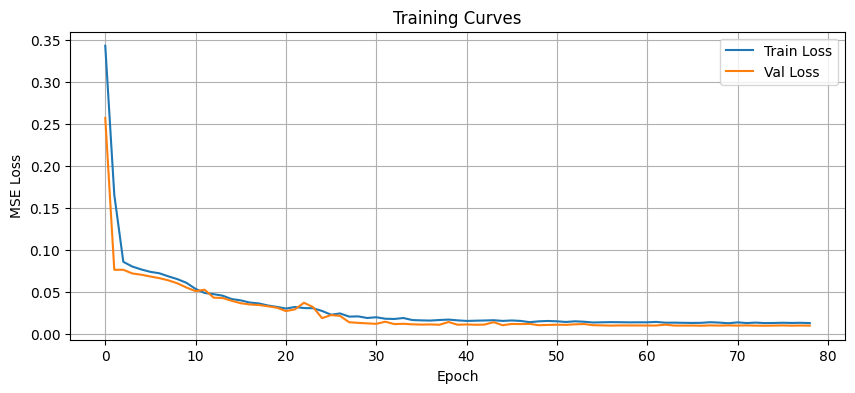

In [11]:
epochs = 200
patience = 12
best_val_loss = float('inf')
early_stop_counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # prevent explosion
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            out = model(Xb)
            val_loss += criterion(out, yb).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_lstm_traffic_model.pth')
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train: {train_loss:.5f} | Val: {val_loss:.5f}")

# Plot losses
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


Test MAE:  135.86 vehicles/hour
Test RMSE: 175.82 vehicles/hour


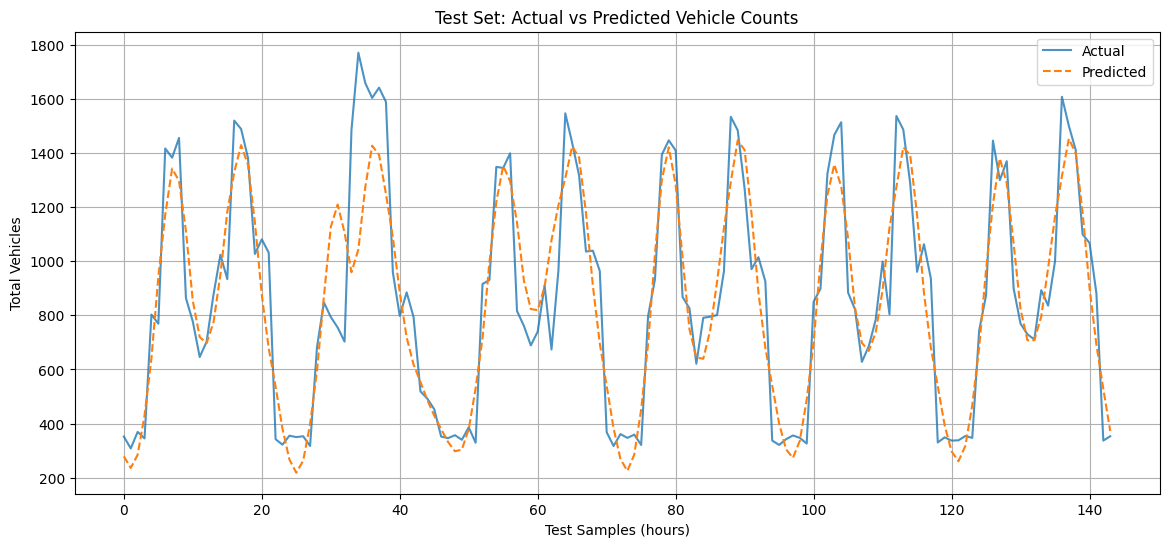

In [12]:
model.load_state_dict(torch.load('best_lstm_traffic_model.pth'))
model.eval()

with torch.no_grad():
    preds_scaled = model(X_test).numpy().flatten()
    ytrue_scaled = y_test.numpy().flatten()

# Inverse scale
def inverse_scale(arr):
    dummy = np.zeros((len(arr), len(features)))
    dummy[:,0] = arr
    return scaler.inverse_transform(dummy)[:,0]

preds = inverse_scale(preds_scaled)
ytrue = inverse_scale(ytrue_scaled)

mae  = mean_absolute_error(ytrue, preds)
rmse = np.sqrt(mean_squared_error(ytrue, preds))
print(f"\nTest MAE:  {mae:.2f} vehicles/hour")
print(f"Test RMSE: {rmse:.2f} vehicles/hour")

# Plot test predictions
plt.figure(figsize=(14,6))
plt.plot(ytrue, label='Actual', alpha=0.8)
plt.plot(preds,  label='Predicted', linestyle='--')
plt.title('Test Set: Actual vs Predicted Vehicle Counts')
plt.xlabel('Test Samples (hours)')
plt.ylabel('Total Vehicles')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
torch.save(model.state_dict(), 'best_lstm_traffic_model.pth')  # already saved, but confirm
joblib.dump(scaler, 'scaler.pkl')

from google.colab import files
files.download('best_lstm_traffic_model.pth')
files.download('scaler.pkl')
files.download('historical_traffic_hourly.csv')

print("\nAll files ready for Flask app:")
print("• best_lstm_traffic_model.pth")
print("• scaler.pkl")
print("• historical_traffic_hourly.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


All files ready for Flask app:
• best_lstm_traffic_model.pth
• scaler.pkl
• historical_traffic_hourly.csv


/tmp/ipython-input-416/1637659564.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_ts = pd.date_range(last_ts + pd.Timedelta(hours=1), periods=72, freq='H')


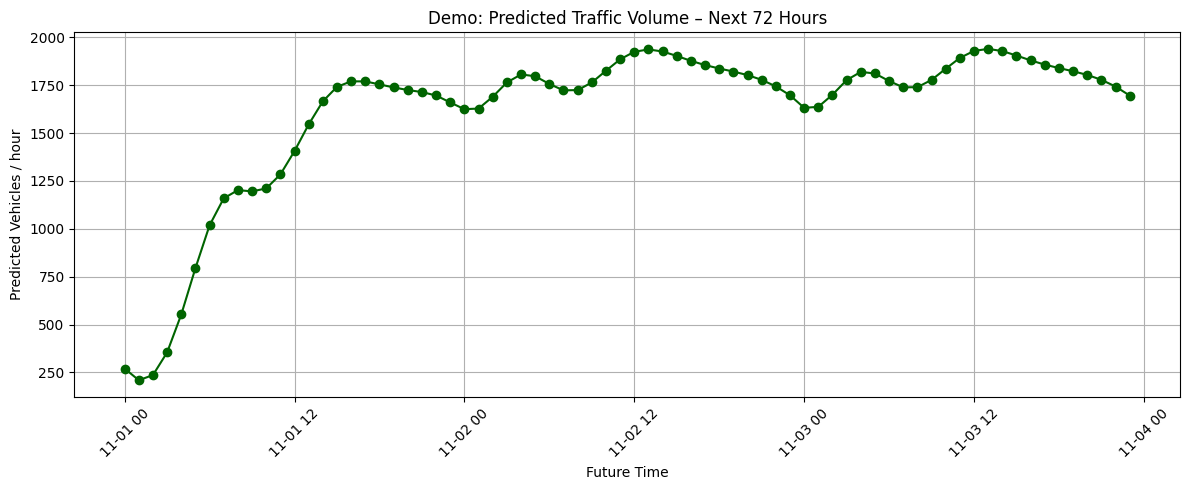

In [14]:
last_seq = torch.from_numpy(data_scaled[-look_back:]).float().unsqueeze(0)

future_preds_scaled = []
current_seq = last_seq.clone()

with torch.no_grad():
    for _ in range(72):
        p = model(current_seq).item()
        future_preds_scaled.append(p)
        new_row = np.array([[p, (len(df_hourly) + len(future_preds_scaled)) % 24,
                             (df_hourly.index[-1].weekday() + (len(future_preds_scaled) // 24)) % 7]])
        new_scaled = scaler.transform(new_row)
        current_seq = torch.cat((current_seq[:,1:,:], torch.from_numpy(new_scaled).float().unsqueeze(0)), dim=1)

future_preds = inverse_scale(np.array(future_preds_scaled))

last_ts = df_hourly.index[-1]
future_ts = pd.date_range(last_ts + pd.Timedelta(hours=1), periods=72, freq='H')

plt.figure(figsize=(12,5))
plt.plot(future_ts, future_preds, marker='o', color='darkgreen')
plt.title('Demo: Predicted Traffic Volume – Next 72 Hours')
plt.xlabel('Future Time')
plt.ylabel('Predicted Vehicles / hour')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()